In [1]:
def createTestSet(loc_idx_1, loc_idx_2, coordinates):
    audio_index_1 = 0
    audio_index_2 = 0
    src_1 = AudioSignal(path=src_1_path[audio_index_1], slice_duration=frameDuration)
    src_2 = AudioSignal(path=src_2_path[audio_index_2], slice_duration=frameDuration)
    # binaural_sig = BinauralSignal(hrir=hrirSet, fs_hrir=fs_HRIR, fs_audio=src_1.fs_audio)
    # binaural_cues = BinauralCues(fs_audio=src_1.fs_audio, prep_method="standardise")

    slice_idx_1 = 0
    slice_idx_2 = 0
    count = 0
    while True:
        # print(f"Current audio (src 1): {audio_index_1}, and (src 2): {audio_index_2}")
        # print(f"Number of slices (audio 1): {len(src_1.slice_list)}, and (audio 2): {len(src_2.slice_list)}")
        if slice_idx_1 >= len(src_1.slice_list):
            slice_idx_1 = 0
            audio_index_1 += 1
            src_1 = AudioSignal(path=src_1_path[audio_index_1], slice_duration=frameDuration)
            
        if slice_idx_2 >= len(src_2.slice_list):
            slice_idx_2 = 0
            audio_index_2 += 1
            src_2 = AudioSignal(path=src_2_path[audio_index_2], slice_duration=frameDuration)
        

        sig_sliced_1 = src_1(idx=slice_idx_1)
        sig_sliced_1 = src_1.apply_gain(sig_sliced_1, target_power=-20)
        sig_sliced_2 = src_2(idx=slice_idx_2)
        sig_sliced_2 = src_2.apply_gain(sig_sliced_2, target_power=-20)

        sigL_1, sigR_1 = binaural_sig(sig_sliced_1, loc_idx_1)
        sigL_2, sigR_2 = binaural_sig(sig_sliced_2, loc_idx_2)
        magL, phaseL, magR, phaseR = binaural_cues(sigL_1+sigL_2, sigR_1+sigR_2)

        # save_cues(cuesList=[magL, phaseL, magR, phaseR], locIndex=[loc_idx_1, loc_idx_2])
        # if save_cues.fileCount == Nsample:
        #     return
        test_cues[count] = torch.tensor([magL, phaseL, magR, phaseR]).permute(1,2,0)

        if coordinates.lower() == "spherical":
            test_label[count] = torch.from_numpy(degree2Radian(np.concatenate((locLabel[loc_idx_1], locLabel[loc_idx_2]), axis=-1)))
        elif coordinates.lower() == "cartesian":
            test_label[count] = torch.from_numpy(
                np.concatenate(
                    (spherical2Cartesian(locLabel[loc_idx_1]), spherical2Cartesian(locLabel[loc_idx_2])),
                    axis=-1
                )
        )
        
        count += 1
        if count >= Nsample:
            return

        slice_idx_1 += 1
        slice_idx_2 += 1
        # print(count)

In [ ]:
def createTestSet_2(frame_duration):
    """load HRIRs and audio files"""
    hrirSet, locLabel, fs_HRIR = loadHRIR(args.hrirDir + "/IRC*")
    src_1_path = glob(os.path.join(args.trainAudioDir+"/speech_male/*"))
    src_2_path = glob(os.path.join(args.trainAudioDir+"/speech_female/*"))
    print(f"Total available number of audio files: {len(src_1_path)}, {len(src_2_path)}")
    
    src_1_count = 0
    src_2_count = 0
    for i in range(len(src_1_path)):
        src_1 = AudioSignal(path=src_1_path[i], slice_duration=frame_duration)
        src_1_count += len(src_1.slice_list)
    for i in range(len(src_2_path)):
        src_2 = AudioSignal(path=src_2_path[i], slice_duration=frame_duration)
        src_2_count += len(src_2.slice_list)
    print(f"Total available number of audio slices: {src_1_count}, {src_2_count}")
    
    # audio indexes
    """Instantiate binaural cue classes"""
    audio_index_1 = 0
    audio_index_2 = 0
    src_1 = AudioSignal(path=src_1_path[audio_index_1], slice_duration=frame_duration)
    src_2 = AudioSignal(path=src_2_path[audio_index_2], slice_duration=frame_duration)
    binaural_sig = BinauralSignal(hrir=hrirSet, fs_hrir=fs_HRIR, fs_audio=src_1.fs_audio)
    loc_region = LocRegion(locLabel=locLabel)
    binaural_cues = BinauralCues(fs_audio=src_1.fs_audio, prep_method="standardise")
    save_cues = SaveCues(savePath=args.cuesDir+"/", locLabel=locLabel)
    
    slice_idx_1 = 0
    slice_idx_2 = 0
    count = 0
    start_time = time.time()
    timeFlag = True
    # start with male-female
    flag = [1, 0]
    while True:
        print(f"Current audio (src 1): {audio_index_1}, and (src 2): {audio_index_2}")
        print(f"Number of slices (audio 1): {len(src_1.slice_list)}, and (audio 2): {len(src_2.slice_list)}")
        print(f"Source indexes: {slice_idx_1, slice_idx_2}")
        print(f"Flag: {flag}")
    
        if slice_idx_1 >= len(src_1.slice_list)-1:
            slice_idx_1 = 0
            audio_index_1 += 1
        if slice_idx_2 >= len(src_2.slice_list)-1:
            slice_idx_2 = 0
            audio_index_2 += 1
        
        src_1 = AudioSignal(path=src_1_path[audio_index_1], slice_duration=frame_duration)
        src_2 = AudioSignal(path=src_2_path[audio_index_2], slice_duration=frame_duration)

        if flag == [1,0]:
            sig_sliced_1 = src_1(idx=slice_idx_1)
            sig_sliced_2 = src_2(idx=slice_idx_2)
            flag = [0,1]
        elif flag == [0,1]:
            sig_sliced_1 = src_2(idx=slice_idx_2)
            sig_sliced_2 = src_1(idx=slice_idx_1)
            flag = [1,1]
        elif flag == [1,1]:
            sig_sliced_1 = src_1(idx=slice_idx_1)
            slice_idx_1 += 1
            sig_sliced_2 = src_1(idx=slice_idx_1)
            flag = [0,0]
        elif flag == [0,0]:
            sig_sliced_1 = src_2(idx=slice_idx_2)
            slice_idx_2 += 1
            sig_sliced_2 = src_2(idx=slice_idx_2)
            flag = [1,0]

        sig_sliced_1 = src_1.apply_gain(sig_sliced_1, target_power=-20)
        sig_sliced_2 = src_2.apply_gain(sig_sliced_2, target_power=-20)

        for loc_idx_1 in loc_region.high_left + loc_region.low_left + loc_region.azim_dict[0] + loc_region.azim_dict[180]:
            for loc_idx_2 in loc_region.high_right + loc_region.low_right + loc_region.azim_dict[0] + loc_region.azim_dict[180]:
                if (loc_idx_1 in loc_region.azim_dict[0] and loc_idx_2 in loc_region.azim_dict[0]) \
                    or (loc_idx_1 in loc_region.azim_dict[180] and loc_idx_2 in loc_region.azim_dict[180]):
                    continue

                sigL_1, sigR_1 = binaural_sig(sig_sliced_1, loc_idx_1)
                sigL_2, sigR_2 = binaural_sig(sig_sliced_2, loc_idx_2)
                magL, phaseL, magR, phaseR = binaural_cues(sigL_1+sigL_2, sigR_1+sigR_2)
                # print(f"magL shape: {magL.shape}")

                save_cues(cuesList=[magL, phaseL, magR, phaseR], locIndex=[loc_idx_1, loc_idx_2])
                if save_cues.fileCount == args.Nsample:
                    return
            if timeFlag:
                print(f"One location loop costs {(time.time()-start_time)} seconds.")
                timeFlag = False

        slice_idx_1 += 1
        slice_idx_2 += 1
        count += 1
        print(count)
        if count >= src_1_count or count >= src_2_count or audio_index_1 >= len(src_1_path)-1 or audio_index_2 >= len(src_2_path)-1:
            return

# Two-source confusion heatmap

In [1]:
from glob import glob
import os
import soundfile as sf
import torch
import torch.nn as nn

from data_loader import *
from utils import *
from utils_train import *
from models import *
from loss import *

"""definition"""
Nfreq = 512
Ntime = 72
Ncues = 4
Nsound = 2
task = "allRegression"
whichDec = "src"
numEnc = 3
coordinates = "spherical"
frameDuration = 1
isHPC = True
num_workers = 0
Nsample = 8
batch_size = 8

"""directories"""
hrir_dir = "./HRTF"
model_dir = "D:/SSSL-D/model/HPC/1008_2Sound_src/"
src_1_path = glob(os.path.join("./audio_valid/speech_male" + "/*"))
src_2_path = glob(os.path.join("./audio_valid/speech_female" + "/*"))

"""load HRIR"""
path = hrir_dir + "/IRC*"
hrirSet, locLabel, fs_HRIR = loadHRIR(path)
"""create a tensor that stores all testing examples"""
test_cues = torch.empty((Nsample, Nfreq, Ntime, Ncues))
if coordinates.lower() == "spherical":
    test_label = torch.empty((Nsample, 2*Nsound))
elif coordinates.lower() == "cartesian":
    test_label = torch.empty((Nsample, 3*Nsound))
"""load model"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(
    task=task,
    Ntime=Ntime,
    Nfreq=Nfreq,
    Ncues=Ncues,
    Nsound=Nsound,
    whichEnc="diy",
    whichDec=whichDec,
    device=device,
    numEnc=numEnc,
    coordinates=coordinates
    # numFC=numFC,
)
if isHPC:
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model = model.to(device)
checkpoint = torch.load(model_dir+"param_bestValLoss.pth.tar")
model.load_state_dict(checkpoint['model'], strict=True)

cost_func = CostFunc(task=task, Nsound=Nsound, device=device)

src_1 = AudioSignal(path=src_1_path[0], slice_duration=frameDuration)
binaural_sig = BinauralSignal(hrir=hrirSet, fs_hrir=fs_HRIR, fs_audio=src_1.fs_audio)
binaural_cues = BinauralCues(fs_audio=src_1.fs_audio, prep_method="standardise")
loc_region = LocRegion(locLabel=locLabel)
loc_1 = [i for i in loc_region.elev_dict[0] if i in loc_region.low_left+loc_region.high_left]
loc_1 = loc_region.low_left+loc_region.high_left
loc_2 = loc_region.low_right+loc_region.high_right+loc_region.azim_dict[180]+loc_region.azim_dict[0]


confusion_heatmap = torch.zeros(187,187)
for loc_idx_1 in range(0, len(loc_1), 1):
    for loc_idx_2 in range(0, len(loc_2), 1):
        print(f"plotting: {loc_1[loc_idx_1]} and {loc_2[loc_idx_2]}")
        createTestSet(loc_1[loc_idx_1], loc_2[loc_idx_2], coordinates=coordinates)
        createTestSet_2(frameDuration)

        dataset = TensorDataset(test_cues, test_label)

        test_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        """model inference"""
        test_correct = 0.0
        test_total = 0.0
        test_sum_loss = 0.0
        test_loss = 0.0
        test_acc = 0.0
        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader, 0):
                inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
                outputs = model(inputs)
                if coordinates.lower() == "cartesian":
                    outputs = cartesian2Spherical(outputs)
                    labels = cartesian2Spherical(labels)
                test_loss = cost_func(outputs, labels)
                test_sum_loss += test_loss.item()
            test_loss = test_sum_loss / (i + 1)
            test_acc = radian2Degree(test_loss)
            confusion_heatmap[loc_1[loc_idx_1], loc_2[loc_idx_2]] = test_acc
            print('Location : Test Loss: %.04f | RMS angle error (degree): %.04f '
                % (test_loss, test_acc))

KeyboardInterrupt: 

tensor([     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000, 856145.1250,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000,      0.0000, 260091.6406,
             0.0000,      0.0000,      0.0000,      0.0000, 198604.2969,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000, 360102.8750,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000, 286389.1250,      0.0000,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
        428667.3438,      0.0000,      0.0000,      0.0000,      0.0000,
        100040.9297,      0.0000,      0.0000,     

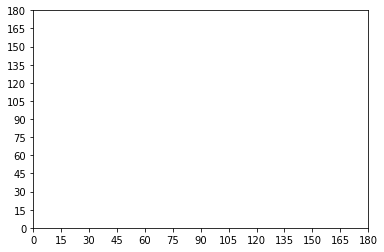

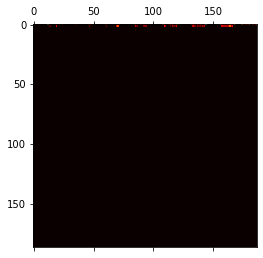

In [11]:
import matplotlib.pyplot as plt

print(confusion_heatmap[1,:])
confusion_heatmap[confusion_heatmap<10] = 0
confusion_heatmap[confusion_heatmap>50] *= 10
print(confusion_heatmap[1,:])

fig, ax = plt.subplots()

# im = ax.imshow(confusion_heatmap*100)
plt.matshow(confusion_heatmap, cmap='hot')
ax.set_xticks(np.arange(0,187,15))
ax.set_yticks(np.arange(0,187,15))
# ax.set_xticklabels("source 1")
# ax.set_yticklabels("source 2")

# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Two-source error plots
RMS angle error vs elev

RMS angle error vs azim

In [2]:
class TwoSourceError:
    def __init__(self, type_error:str):
        self.error = {}
        self.type_error = type_error

    def __call__(self, idx, loss):
        loss = radian2Degree(loss)
        if not (idx in self.error):
            self.error[idx] = [loss]
        else:
            self.error[idx].append(loss)

In [3]:
from glob import glob
import os
import soundfile as sf
import torch
import torch.nn as nn

from data_loader import *
from utils import *
from utils_train import *
from models import *
from loss import *

"""definition"""
Nfreq = 512
Ntime = 72
Ncues = 4
Nsound = 2
task = "allRegression"
whichDec = "src"
numEnc = 6
coordinates = "spherical"
frameDuration = 1
isHPC = True
num_workers = 0
Nsample = 8
batch_size = 8

"""directories"""
hrir_dir = "./HRTF"
model_dir = "D:/SSSL-D/model/HPC/1208_2Sound_src_enc6/"
src_1_path = glob(os.path.join("./audio_test/speech_male" + "/*"))
src_2_path = glob(os.path.join("./audio_test/speech_female" + "/*"))

"""load HRIR"""
path = hrir_dir + "/IRC*"
hrirSet, locLabel, fs_HRIR = loadHRIR(path)
"""create a tensor that stores all testing examples"""
test_cues = torch.empty((Nsample, Nfreq, Ntime, Ncues))
if coordinates.lower() == "spherical":
    test_label = torch.empty((Nsample, 2*Nsound))
elif coordinates.lower() == "cartesian":
    test_label = torch.empty((Nsample, 3*Nsound))
"""load model"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(
    task=task,
    Ntime=Ntime,
    Nfreq=Nfreq,
    Ncues=Ncues,
    Nsound=Nsound,
    whichEnc="diy",
    whichDec=whichDec,
    device=device,
    numEnc=numEnc,
    coordinates=coordinates
    # numFC=numFC,
)
if isHPC:
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model = model.to(device)
checkpoint = torch.load(model_dir+"param_bestValLoss.pth.tar")
model.load_state_dict(checkpoint['model'], strict=True)

cost_func = CostFunc(task=task, Nsound=Nsound, device=device)

src_1 = AudioSignal(path=src_1_path[0], slice_duration=frameDuration)
binaural_sig = BinauralSignal(hrir=hrirSet, fs_hrir=fs_HRIR, fs_audio=src_1.fs_audio)
binaural_cues = BinauralCues(fs_audio=src_1.fs_audio, prep_method="standardise")
loc_region = LocRegion(locLabel=locLabel)
loc_1 = [i for i in loc_region.elev_dict[0] if i in loc_region.low_left+loc_region.high_left]
loc_1 = loc_region.low_left+loc_region.high_left
loc_2 = loc_region.low_right+loc_region.high_right+loc_region.azim_dict[180]+loc_region.azim_dict[0]

"""Initalise a dictionary that contains keys for each elev/azim location"""
error_elev_1 = TwoSourceError(type_error="elev")
error_elev_2 = TwoSourceError(type_error="elev")
error_azim_1 = TwoSourceError(type_error="azim")
error_azim_2 = TwoSourceError(type_error="azim")

for loc_idx_1 in range(0, len(loc_1), 1):
    for loc_idx_2 in range(0, len(loc_2), 1):
        print(f"plotting: {loc_1[loc_idx_1]} and {loc_2[loc_idx_2]}")
        createTestSet(loc_1[loc_idx_1], loc_2[loc_idx_2], coordinates=coordinates)

        dataset = TensorDataset(test_cues, test_label)

        test_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        """model inference"""
        test_correct = 0.0
        test_total = 0.0
        test_sum_loss = 0.0
        test_loss = 0.0
        test_acc = 0.0
        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader, 0):
                inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
                outputs = model(inputs)
                if coordinates.lower() == "cartesian":
                    outputs = cartesian2Spherical(outputs)
                    labels = cartesian2Spherical(labels)
                
                test_loss = cost_func(outputs, labels)
                test_loss = test_loss.item()
                test_sum_loss += test_loss
                
                elev_1, azim_1 = loc_region.getElev(loc_1[loc_idx_1]), loc_region.getAzim(loc_1[loc_idx_1])
                elev_2, azim_2 = loc_region.getElev(loc_2[loc_idx_2]), loc_region.getAzim(loc_2[loc_idx_2])
                error_elev_1(
                    idx=elev_1,
                    loss=test_loss
                )
                error_azim_1(
                    idx=azim_1,
                    loss=test_loss
                )
                error_elev_2(
                    idx=elev_2,
                    loss=test_loss
                )
                error_azim_2(
                    idx=azim_2,
                    loss=test_loss
                )
            test_loss = test_sum_loss / (i + 1)
            test_acc = radian2Degree(test_loss)
            print('Location : Test Loss: %.04f | RMS angle error (degree): %.04f '
                % (test_loss, test_acc))

[1002]
locLabel shape:  (187, 2)  (order: elev, azim)
HRIR shape after resampling: (187, 2, 186)
Preprocessing method: standardise
Number of locations in each region: 40, 44, 40, 44
plotting: 1 and 13
Location : Test Loss: 0.5799 | RMS angle error (degree): 33.2246 
plotting: 1 and 14
Location : Test Loss: 0.0323 | RMS angle error (degree): 1.8495 
plotting: 1 and 15
Location : Test Loss: 0.0894 | RMS angle error (degree): 5.1229 
plotting: 1 and 16
Location : Test Loss: 0.1581 | RMS angle error (degree): 9.0610 
plotting: 1 and 17
Location : Test Loss: 0.1542 | RMS angle error (degree): 8.8368 
plotting: 1 and 18
Location : Test Loss: 0.5106 | RMS angle error (degree): 29.2551 
plotting: 1 and 19
Location : Test Loss: 0.3317 | RMS angle error (degree): 19.0060 
plotting: 1 and 20
Location : Test Loss: 0.3179 | RMS angle error (degree): 18.2136 
plotting: 1 and 21
Location : Test Loss: 0.2198 | RMS angle error (degree): 12.5934 
plotting: 1 and 22
Location : Test Loss: 0.0144 | RMS ang

KeyboardInterrupt: 

In [40]:
import pickle

with open("./error_azim_1.pkl", "wb") as tf:
    pickle.dump(error_azim_1.error, tf, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
def getRMS(val):
    squared = list(map(lambda x: x ** 2, val))
    return np.sqrt(np.mean(squared))

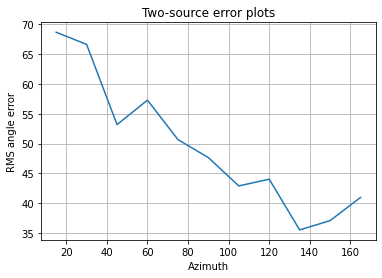

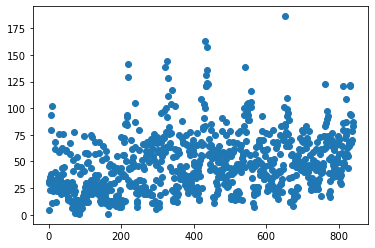

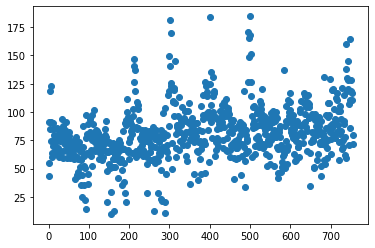

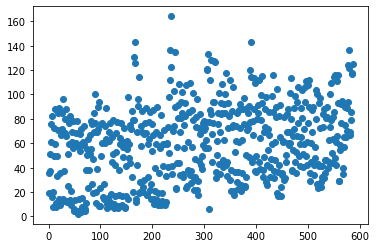

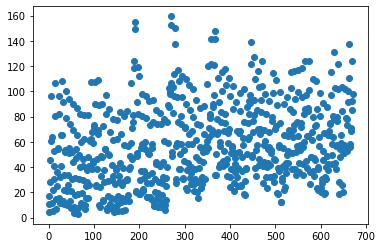

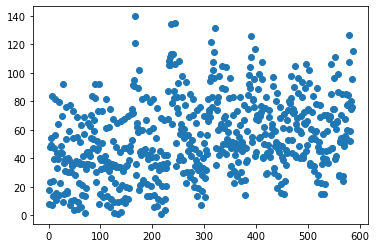

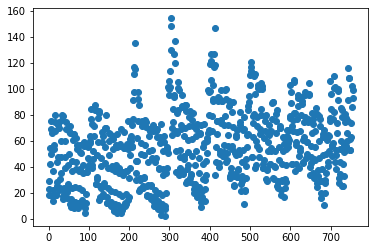

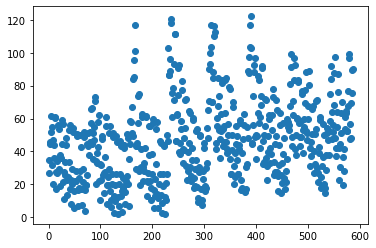

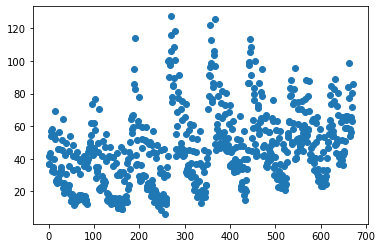

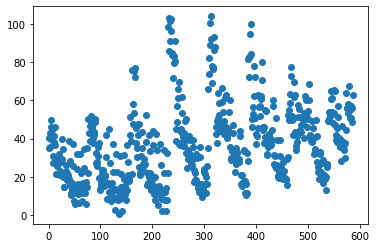

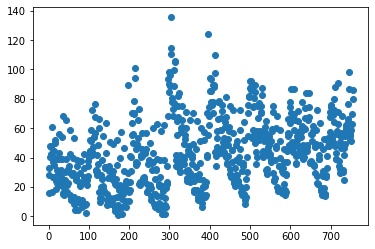

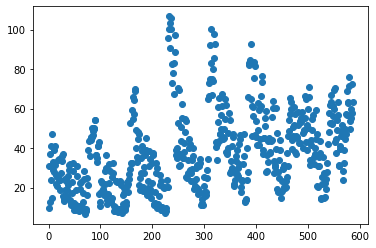

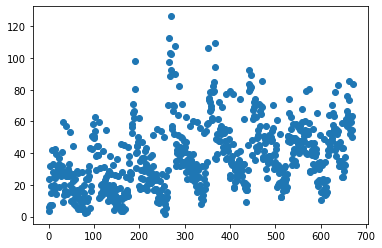

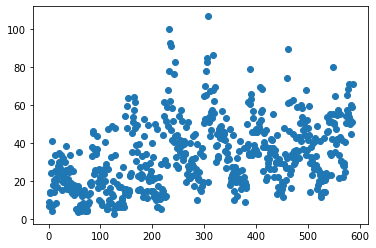

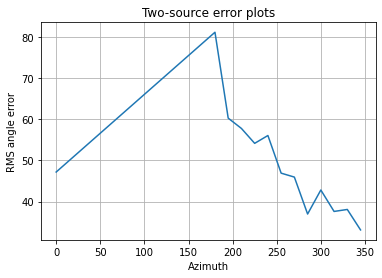

In [42]:
import collections

x_axis = []
y_axis_azim_1 = []
od_azim_1 = collections.OrderedDict(sorted(error_azim_1.error.items()))
for idx in od_azim_1:
    x_axis.append(idx)
    # plt.scatter(range(len(error_azim_1.error[idx])), error_azim_1.error[idx])
    # plt.show()
    y_axis_azim_1.append(np.mean(error_azim_1.error[idx]))
plt.plot(x_axis, y_axis_azim_1)
plt.xlabel("Azimuth")
plt.ylabel("RMS angle error")
plt.title("Two-source error plots")
plt.grid()
plt.show()

x_axis = []
y_axis_azim_2 = []
od_azim_2 = collections.OrderedDict(sorted(error_azim_2.error.items()))
for idx in od_azim_2:
    x_axis.append(idx)
    # plt.scatter(range(len(error_azim_2.error[idx])), error_azim_2.error[idx])
    # plt.show()
    y_axis_azim_2.append(np.mean(error_azim_2.error[idx]))
plt.plot(x_axis, y_axis_azim_2)
plt.xlabel("Azimuth")
plt.ylabel("RMS angle error")
plt.title("Two-source error plots")
plt.grid()
plt.show()


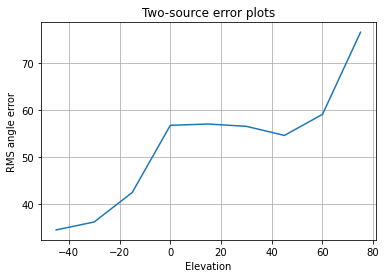

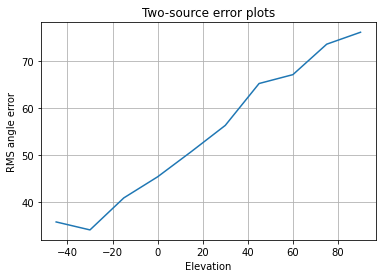

In [37]:
import collections

x_axis = []
y_axis_elev_1 = []
od_elev_1 = collections.OrderedDict(sorted(error_elev_1.error.items()))
for idx in od_elev_1:
    x_axis.append(idx)
    y_axis_elev_1.append(np.mean(error_elev_1.error[idx]))
plt.plot(x_axis, y_axis_elev_1)
plt.xlabel("Elevation")
plt.ylabel("RMS angle error")
plt.title("Two-source error plots")
plt.grid()
plt.show()

x_axis = []
y_axis_elev_2 = []
od_elev_2 = collections.OrderedDict(sorted(error_elev_2.error.items()))
for idx in od_elev_2:
    x_axis.append(idx)
    y_axis_elev_2.append(np.mean(error_elev_2.error[idx]))
plt.plot(x_axis, y_axis_elev_2)
plt.xlabel("Elevation")
plt.ylabel("RMS angle error")
plt.title("Two-source error plots")
plt.grid()
plt.show()

# Read log for single sound source

In [2]:
import pandas as pd
import torch
import torch.nn as nn

log_1Sound_flmr = pd.read_csv("test_log_1Sound.csv", header=None)
print(log_1Sound_flmr[:3])

0  1          2           3          4    5          6
0 -5  0 -47.982089  358.140423 -45.000001  0.0   3.244979
1 -5  0 -45.496757  302.800044 -45.000001  0.0  39.392901
2 -5  0 -58.145305  153.451224 -45.000001  0.0  74.527705


[1002]
locLabel shape:  (187, 2)  (order: elev, azim)
torch.Size([1352, 7])
1488.0 0.34274193548387094
torch.Size([1352, 7])
1488.0 0.47110215053763443
torch.Size([1352, 7])
1488.0 0.5584677419354839
torch.Size([1352, 7])
1488.0 0.6263440860215054
torch.Size([1352, 7])
1488.0 0.678763440860215
torch.Size([1352, 7])
1488.0 0.7452956989247311
torch.Size([1352, 7])
1488.0 0.7983870967741935
torch.Size([1352, 7])
1488.0 0.8333333333333334
torch.Size([1352, 7])
1488.0 0.8581989247311828


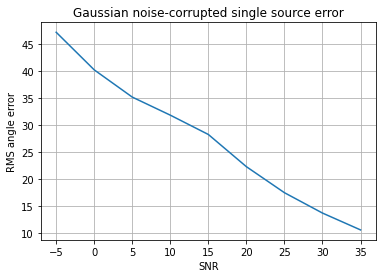

In [74]:
from data_loader import *
from utils_test import *
import matplotlib.pyplot as plt

path = "./HRTF/IRC*"
hrirSet, locLabel, fs_HRIR = loadHRIR(path)

# print(log_flmr.iloc[:,4:])

labels = torch.tensor(log_1Sound_flmr.iloc[:,:].values, dtype=torch.float)

error = []
elev_error = {}
azim_error = {}
valSNRList = [-5,0,5,10,15,20,25,30,35]
for val_SNR in valSNRList:
    """filter for each SNR"""
    filter_1 = labels[:,0].long() == np.int(val_SNR)

    filtered_SNR = labels[:][
        filter_1
    ]
    
    """filter for elevation <= 45 degrees"""
    filtered = filtered_SNR[
        filtered[:,1].long() <= np.int(168)
    ]
    error.append(torch.mean(filtered[:,-1]).item())


    """filter for RMS loss <= 30"""
    print(filtered.shape)
    filter_2 = filtered[:,-1].float() <= np.float(30)
    filtered = filtered[:][
        filter_2
    ]
    print(labels.shape[0]/9, filtered.shape[0]*9/labels.shape[0])

    for _, (elev, azim) in enumerate(locLabel):
        print(f"{elev, azim}")

        filter_elev = labels[:,4].long() == np.int(elev)
        # filter_azim = labels[:,5].long() == np.int(azim)

        filtered = labels[:][
            filter_elev
        ]
        print(f"filtered: {filtered.shape}")
        
    # raise SystemExit

plt.plot(valSNRList, error)
plt.xlabel("SNR")
plt.ylabel("RMS angle error")
plt.title("Gaussian noise-corrupted single source error")
plt.grid()
plt.show()
plt.close()

# Read log for multiple sound sources

In [107]:
import pandas as pd
import torch
import torch.nn as nn

log_mlfr = pd.read_csv("enc6_dropout01_mlfr.csv", header=None)
log_flmr = pd.read_csv("enc6_dropout01_flmr.csv", header=None)
print(log_flmr[:3])

0          1          2           3     4     5     6           7   \
0 -25.027295  15.756166 -14.798691 -164.724656  15.0  15.0  15.0  195.000016   
1 -30.003583  18.213171 -14.510027 -149.646494  15.0  15.0  15.0  209.999999   
2 -29.146985  18.085380  -9.061036 -135.263154  15.0  15.0  15.0  225.000010   

          8          9          10  
0  40.034085  29.799934  69.834019  
1  45.110032  29.512090  74.622122  
2  44.247492  24.062456  68.309948  


In [108]:
from data_loader import *
from utils_test import *

path = "./HRTF/IRC*"
hrirSet, locLabel, fs_HRIR = loadHRIR(path)

# print(log_flmr.iloc[:,4:])

labels = torch.tensor(log_flmr.iloc[:,4:].values, dtype=torch.float)
# print(f"labels: {labels.shape, labels}")

error_elev_1 = {}
error_azim_1 = {}
for _, (elev, azim) in enumerate(locLabel):
    if elev == 0 or azim == 0 or azim >= 180:
        continue

    print(f"{elev, azim}")

    filter_elev_1 = labels[:,0].long() == np.int(elev)
    filter_azim_1 = labels[:,1].long() == np.int(azim)
    filter_1 = torch.logical_and(filter_elev_1, filter_azim_1)

    filtered = labels[:][
        filter_1
    ]
    print(f"filtered: {filtered.shape}")
    
    # RMS angle error of source 1 when source 1 is fixed and source 2 loops through all locations
    # loss = torch.mean(filtered[:,-3])
    loss = torch.sqrt(torch.mean(torch.square(filtered[:,-3])))
    print(loss.item())
    if not loss.item() > 0:
        print(filtered[:,-3])
    if elev not in error_elev_1.keys():
        error_elev_1[elev] = [loss.item()]
    else:
        error_elev_1[elev].append(loss.item())

    if azim not in error_azim_1.keys():
        error_azim_1[azim] = [loss.item()]
    else:
        error_azim_1[azim].append(loss.item())


error_elev_2 = {}
error_azim_2 = {}
for _, (elev, azim) in enumerate(locLabel):
    if elev == 0 or azim == 0 or azim <= 180:
        continue

    print(f"{elev, azim}")

    filter_elev_2 = labels[:,2].long() == np.int(elev)
    filter_azim_2 = labels[:,3].long() == np.int(azim)
    filter_2 = torch.logical_and(filter_elev_2, filter_azim_2)

    filtered = labels[:][
        filter_2
    ]
    print(f"filtered: {filtered.shape}")
    
    # RMS angle error of source 2 when source 2 is fixed and source 1 loops through all locations
    # loss = torch.mean(filtered[:,-3])
    loss = torch.sqrt(torch.mean(torch.square(filtered[:,-2])))
    print(loss.item())
    if not loss.item() > 0:
        print(filtered[:,-2])
    if elev not in error_elev_2.keys():
        error_elev_2[elev] = [loss.item()]
    else:
        error_elev_2[elev].append(loss.item())

    if azim not in error_azim_2.keys():
        error_azim_2[azim] = [loss.item()]
    else:
        error_azim_2[azim].append(loss.item())




[1002]
locLabel shape:  (187, 2)  (order: elev, azim)
(-45, 15)
filtered: torch.Size([103, 7])
16.36188316345215
(-45, 30)
filtered: torch.Size([103, 7])
5.702579975128174
(-45, 45)
filtered: torch.Size([103, 7])
7.948437213897705
(-45, 60)
filtered: torch.Size([103, 7])
2.975254774093628
(-45, 75)
filtered: torch.Size([103, 7])
11.63441276550293
(-45, 90)
filtered: torch.Size([103, 7])
8.505793571472168
(-45, 105)
filtered: torch.Size([103, 7])
3.0560226440429688
(-45, 120)
filtered: torch.Size([103, 7])
0.9370200037956238
(-45, 135)
filtered: torch.Size([103, 7])
1.3819420337677002
(-45, 150)
filtered: torch.Size([103, 7])
1.306149959564209
(-45, 165)
filtered: torch.Size([103, 7])
2.241175889968872
(-30, 15)
filtered: torch.Size([103, 7])
0.2883826494216919
(-30, 30)
filtered: torch.Size([103, 7])
1.0425974130630493
(-30, 45)
filtered: torch.Size([103, 7])
4.6614251136779785
(-30, 60)
filtered: torch.Size([103, 7])
0.15875019133090973
(-30, 75)
filtered: torch.Size([103, 7])
0.57606

elev
-45: 5.640970181335103
-30: 4.042968372052366
-15: 5.839298729192127
15: 15.285962451588023
30: 32.9857610355724
45: 25.67273403297771
60: 21.084817111492157
75: 69.6001148223877
-45: 3.2034116461873055
-30: 4.692741177298806
-15: 3.645727966319431
15: 16.874439326199617
30: 30.916901219974864
45: 32.63362294977362
60: 27.919392395019532
75: 52.543630599975586
<class 'dict_keys'> <class 'list'>


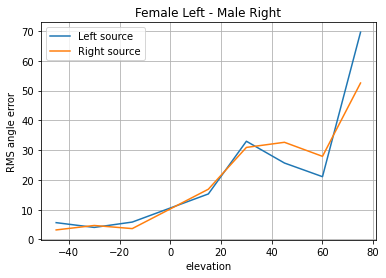

azim
15: 11.568610921502113
30: 5.609494015574455
45: 6.20754071076711
60: 13.824802244082093
75: 9.180257399876913
90: 10.776833925928388
105: 8.358469843864441
120: 22.697450570762157
135: 37.06252694129944
150: 34.26198019300188
165: 24.63139061133067
195: 15.790860349933306
210: 9.588328037943159
225: 10.099601954221725
240: 13.679546743631363
255: 16.592659155527752
270: 16.65488546235221
285: 17.905446170518797
300: 25.387311024591327
315: 22.97742544611295
330: 17.51935058406421
345: 22.87512352069219


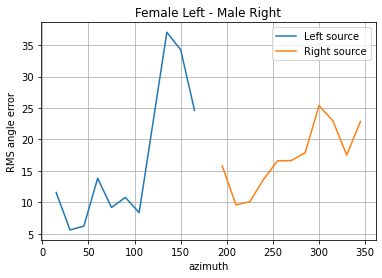

In [109]:
import matplotlib.pyplot as plt

print("elev")
error = []
for i in error_elev_1.keys():
    print(f"{i}: {np.mean(error_elev_1[i])}")
    error.append(np.mean(error_elev_1[i]))
plt.plot(list(error_elev_1.keys()), error)
error = []
for i in error_elev_2.keys():
    print(f"{i}: {np.mean(error_elev_2[i])}")
    error.append(np.mean(error_elev_2[i]))
print(type(error_elev_1.keys()), type(error))
plt.plot(list(error_elev_2.keys()), error)
plt.xlabel("elevation")
plt.ylabel("RMS angle error")
plt.legend(["Left source", "Right source"])
plt.title("Female Left - Male Right")
plt.grid()
plt.show()
plt.close()

print("azim")
error = []
for i in error_azim_1.keys():
    print(f"{i}: {np.mean(error_azim_1[i])}")
    error.append(np.mean(error_azim_1[i]))
plt.plot(list(error_azim_1.keys()), error)
error = []
for i in error_azim_2.keys():
    print(f"{i}: {np.mean(error_azim_2[i])}")
    error.append(np.mean(error_azim_2[i]))
plt.plot(list(error_azim_2.keys()), error)
plt.xlabel("azimuth")
plt.ylabel("RMS angle error")
plt.legend(["Left source", "Right source"])
plt.title("Female Left - Male Right")
plt.grid()
plt.show()
plt.close()


(0, 0)
(0, 2)
(0, 4)
(0, 6)
(0, 8)
(2, 0)
(2, 2)
(2, 4)
(2, 6)
(2, 8)
(4, 0)
(4, 2)
(4, 4)
(4, 6)
(4, 8)
(6, 0)
(6, 2)
(6, 4)
(6, 6)
(6, 8)
(8, 0)
(8, 2)
(8, 4)
(8, 6)
(8, 8)
bias (0, 25)
(1, 1)
(1, 3)
(1, 5)
(1, 7)
(1, 9)
(3, 1)
(3, 3)
(3, 5)
(3, 7)
(3, 9)
(5, 1)
(5, 3)
(5, 5)
(5, 7)
(5, 9)
(7, 1)
(7, 3)
(7, 5)
(7, 7)
(7, 9)
(9, 1)
(9, 3)
(9, 5)
(9, 7)
(9, 9)
bias (1, 50)
(2, 2)
(2, 4)
(2, 6)
(2, 8)
(4, 2)
(4, 4)
(4, 6)
(4, 8)
(6, 2)
(6, 4)
(6, 6)
(6, 8)
(8, 2)
(8, 4)
(8, 6)
(8, 8)
bias (2, 66)
(3, 3)
(3, 5)
(3, 7)
(3, 9)
(5, 3)
(5, 5)
(5, 7)
(5, 9)
(7, 3)
(7, 5)
(7, 7)
(7, 9)
(9, 3)
(9, 5)
(9, 7)
(9, 9)
bias (3, 82)


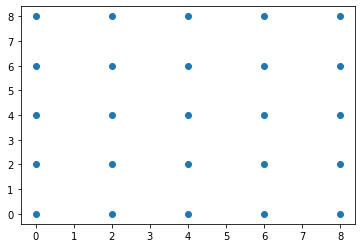

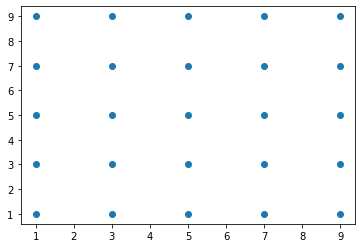

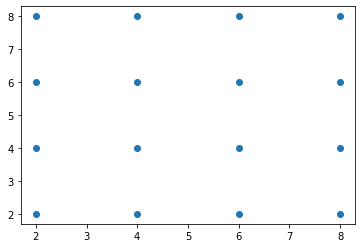

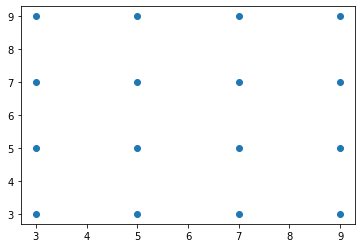

In [32]:
import matplotlib.pyplot as plt
count = 0
loc_1 = {}
loc_2 = {}
for bias in range(0,4):
    loc_1[bias]=[]
    loc_2[bias]=[]
    for i in range(bias,10,2):
        for j in range(bias,10,2):
            # if count <= 50:
            print(f"{i,j}")
            loc_1[bias].append(i)
            loc_2[bias].append(j)
            count += 1
    print(f"bias {bias, count}")

for bias in range(0,4):
    plt.scatter(loc_1[bias], loc_2[bias])
    plt.show()

In [1]:
import numpy as np
from data_loader import *


load_hrir = LoadHRIR(path="./HRTF/IRC*")
speech_male_path = glob(os.path.join("./audio_train/speech_male/*"))
speech_female_path = glob(os.path.join("./audio_train/speech_female/*"))
audio_sig = AudioSignal(path=speech_male_path[0], slice_duration=1)
sig_sliced = audio_sig(idx=1)

binaural_sig = BinauralSignal(load_hrir.hrir_set, load_hrir.fs_HRIR, audio_sig.fs_audio)


HRIR set shape: (187, 2, 512), loc Label shape: (186, 2)
Number of locations in each region: 40, 33, 40, 33
HRIR shape after resampling: (187, 2, 186)


In [2]:

binaural_sig = BinauralSignal(load_hrir.hrir_set, load_hrir.fs_HRIR, audio_sig.fs_audio, val_SNR=0)
a = np.array(range(1,10))
print(np.mean(np.power(a, 2)))
print(np.mean(np.power(binaural_sig.noiseGenerator(a),2)))

HRIR shape after resampling: (187, 2, 186)
31.666666666666668
4.213401828809432


In [3]:
import scipy as sp
import scipy.fftpack as fft

# frequency
f1 = 1000.0
Fs = 8000.0  # sampling frequency

# amplitudes
amp1 = 0.75

# time
n = sp.arange(1024)

# Desired SNR in dB
SNR_dB = 0

# Desired linear SNR
snr = 10.0**(SNR_dB/10.0)
print("Linear snr = ", snr)

# Measure power of signal
signal1 = amp1*sp.sin(2*sp.pi*f1/Fs*n) +100
p1 = signal1.var()
print("Power of signal1 = ", p1)

# Calculate required noise power for desired SNR
n = p1/snr
print("Noise power = ", n)
print("Calculated SNR =  %f dB" % (10*sp.log10(p1/n)))

# Generate noise with calculated power
w = sp.sqrt(n)*sp.randn(1024)
print(np.mean(np.power(w, 2)))
print(np.mean(np.power(binaural_sig.noiseGenerator(signal1),2)))
# Add noise to signal
s1 = signal1 + w
s2 = signal1 + binaural_sig.noiseGenerator(signal1)
print("signal 1 mean power (db): ", 10*np.log10(np.mean(np.power(s2, 2))))

gained = audio_sig.apply_gain(s2, 0)
print(10*np.log10(np.mean(np.power(gained, 2))))

Linear snr =  1.0
Power of signal1 =  0.28125000000000006
Noise power =  0.28125000000000006
Calculated SNR =  0.000000 dB
0.2830321539072247
0.28622079084383867
signal 1 mean power (db):  39.99989213416622
60.86614748689966


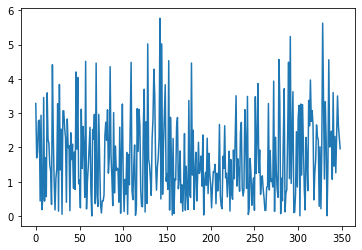

In [36]:
power_list = []
for i in speech_female_path:
    audio_sig = AudioSignal(path=i, slice_duration=1)
    
    for j in range(len(audio_sig.slice_list)):
        sig_sliced = audio_sig(idx=j)
        sig_sliced = audio_sig.apply_gain(sig_sliced, 0)
        # print("signal 1 mean power (db): ", 10*np.log10(np.mean(np.power(sig_sliced, 2)))
        power_list.append(10*np.log10(np.mean(np.power(sig_sliced, 2))))

import matplotlib.pyplot as plt
plt.plot(range(len(power_list)), power_list)
plt.show()

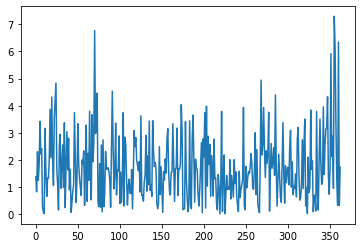

In [37]:
power_list_2 = []
for i in speech_male_path:
    audio_sig = AudioSignal(path=i, slice_duration=1)
    
    for j in range(len(audio_sig.slice_list)):
        sig_sliced = audio_sig(idx=j)
        sig_sliced = audio_sig.apply_gain(sig_sliced, 0)
        # print("signal 1 mean power (db): ", 10*np.log10(np.mean(np.power(sig_sliced, 2)))
        power_list_2.append(10*np.log10(np.mean(np.power(sig_sliced, 2))))

import matplotlib.pyplot as plt
plt.plot(range(len(power_list_2)), power_list_2)
plt.show()

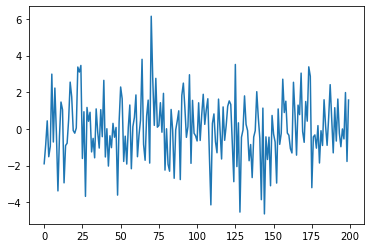

In [38]:
import matplotlib.pyplot as plt

plt.plot(range(200), [power_list_2[i]-power_list[i] for i in range(200)])
plt.show()

In [29]:
from utils import *

audio_sig_1 = AudioSignal(path=speech_male_path[0], slice_duration=1)
audio_sig_2 = AudioSignal(path=speech_female_path[0], slice_duration=1)
sig_sliced_1 = audio_sig_1(idx=0)
sig_sliced_2 = audio_sig_2(idx=0)

print(np.mean(np.power(sig_sliced_1, 2)))
print(np.mean(np.power(sig_sliced_2, 2)))

sig_sliced_1 *= np.sqrt(
    -10/linear2dbfs(np.mean(np.power(sig_sliced_1, 2)))
)
sig_sliced_2 *= np.sqrt(
    -10/linear2dbfs(np.mean(np.power(sig_sliced_2, 2)))
)

print(linear2dbfs(np.mean(np.power(sig_sliced_1, 2))))
print(linear2dbfs(np.mean(np.power(sig_sliced_2, 2))))

0.01124945041112369
0.0018934568406548352
-50.793625388360546
-69.17562978238053
